## Задание 1
#### Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

#### В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from tqdm.auto import tqdm

%matplotlib inline
sns.set(rc={"figure.figsize": (14, 6)})  # width=14, #height=6

In [2]:
# разбивка пользователей на контрольную (А) и тестовую (В) группы
groups = pd.read_csv("Проект_4_groups.csv")
groups.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [3]:
groups.value_counts(
    "group"
)  # оценим размеры выборок: тестовая группа примерно в 4 раза больше контрольной

group
B    59883
A    14693
dtype: int64

In [4]:
# информация о пользователях, которые посещали приложение во время эксперимента
active_users = pd.read_csv("Проект_4_active_users.csv")
active_users.head()

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [5]:
groups.merge(active_users, how="right", on="user_id").value_counts("group")

group
B    6803
A    1538
dtype: int64

In [6]:
# данные о транзакциях (оплатах) пользователей приложения во время эксперимента
purchases = pd.read_csv("Проект_4_purchases.csv")
purchases.head()

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0


In [7]:
groups.merge(purchases, how="right", on="user_id").value_counts("group")

group
B    434
A    107
dtype: int64

#### Заметим, что в каждом датафрейме элементов в группе (B) примерно в 4 раза больше, чем в группе (А).
#### Однако размеры группы (А) достаточно велики, чтобы выдвинуть предположение о том, что поведение наших пользователей при бОльших размерах группы будет аналогичным.
#### В качестве ключевых метрик я буду использовать средний/медианный показатель дохода по платящим пользователям ARPPU (т.к. основной метрикой для большинства продуктов является количество денег, которое он приносит) и их конверсию в покупку (CR в событие показывает, насколько услуга актуальна и востребована).
#### Важно отметить, что, например, метрика вовлечённости пользователей (соотношение автивных пользователей и пользователей, не посетивших приложение во время эксперимента) никак не коррелирует с проводимым тестом: неактивные пользователи попросту не могли попробовать новую модель оплаты.

In [8]:
# Оценим медианные и средние показатели дохода с пользователей по группам.
# Заметим, что в группе (B) оба значения выросли в 1.35 и в 1.29 раза соответственно.
groups.merge(purchases, how="right", on="user_id").groupby("group", as_index=False).agg(
    {"revenue": ["median", "mean"]}
)

group revenue             
         median         mean
0     A   698.0   870.672897
1     B   944.0  1118.836406

In [9]:
# Проанализируем результаты в разрезах по стране, платформе и полу пользователей.
# Объединим в единый датафрейм всех активных пользователей вне зависимости от наличия оплаты:
summary = groups.merge(active_users, how="right", on="user_id").merge(
    purchases, how="left", on="user_id"
)
summary.head()

,user_id,group,country,platform,sex,revenue
0,8029,B,Russia,ios,male,NaN
1,1735,B,Sweden,ios,male,NaN
2,7697,B,Russia,android,male,NaN
3,1421,B,Sweden,android,female,NaN
4,1704,B,Russia,ios,male,NaN


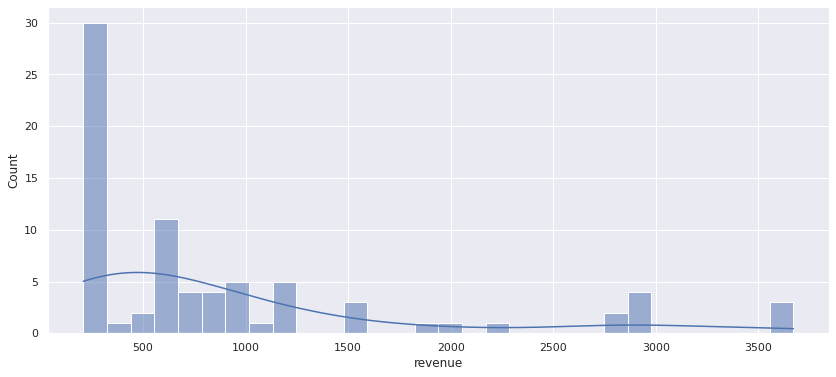

In [10]:
sns.histplot(summary.query('group == "A"').revenue, bins=30, kde=True);

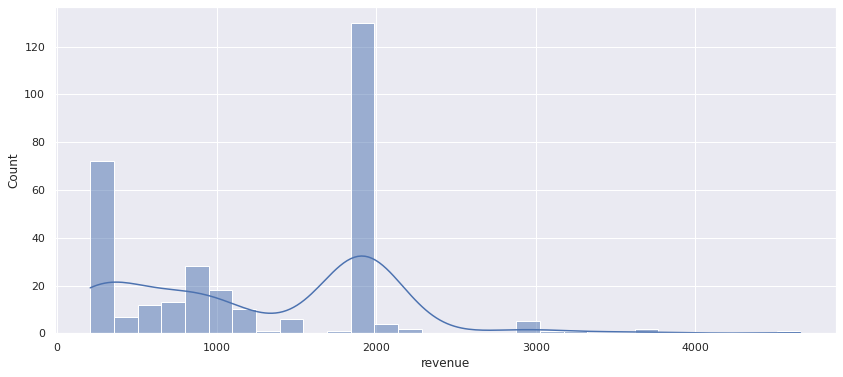

In [11]:
sns.histplot(summary.query('group == "B"').revenue, bins=30, kde=True);

#### Наши распределения очень ассиметричны, поэтому в качестве сравнения на первом этапе будем использовать медианные значения дохода:

In [12]:
revenue_by_country = (
    summary.groupby(["group", "country"], as_index=False)
    .agg({"revenue": "median"})
    .pivot(index="group", columns="country", values="revenue")
)
revenue_by_country.head()

country,Russia,Sweden
group,,
A,590.0,698.0
B,1001.0,1908.0


In [13]:
revenue_by_platform = (
    summary.groupby(["group", "platform"], as_index=False)
    .agg({"revenue": "median"})
    .pivot(index="group", columns="platform", values="revenue")
)
revenue_by_platform.head()

platform,android,ios
group,,
A,600.0,590.0
B,1151.0,1170.0


In [14]:
revenue_by_sex = (
    summary.groupby(["group", "sex"], as_index=False)
    .agg({"revenue": "median"})
    .pivot(index="group", columns="sex", values="revenue")
)
revenue_by_sex.head()

sex,female,male
group,,
A,590.0,600.0
B,1908.0,1000.5


#### Заметим, что в разрезе по каждому параметру медианный показатель дохода существенно возрос.
#### Теперь проверим статистическую значимость полученных результатов:

In [15]:
# И для данного этапа анализа отберём только пользователей, совершивших оплату:
summary_with_revenue = summary[summary["revenue"].notna()]
summary_with_revenue.head()

,user_id,group,country,platform,sex,revenue
45,1202,A,Sweden,android,male,302.0
58,6284,B,Russia,android,female,208.0
63,6554,B,Sweden,android,female,602.0
101,6000,B,Sweden,ios,male,1910.0
117,4046,B,Sweden,ios,female,1909.0


In [16]:
summary_with_revenue.revenue.isna().sum()

0

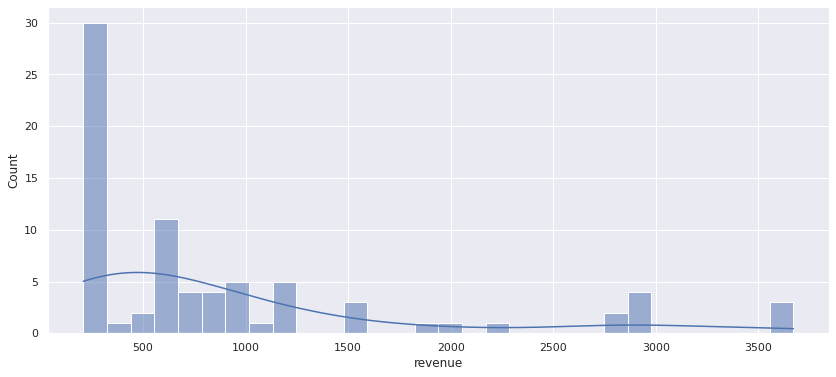

In [17]:
# Еще раз взглянем на графики распределения показателя дохода по группам:
sns.histplot(summary_with_revenue.query('group == "A"').revenue, bins=30, kde=True);

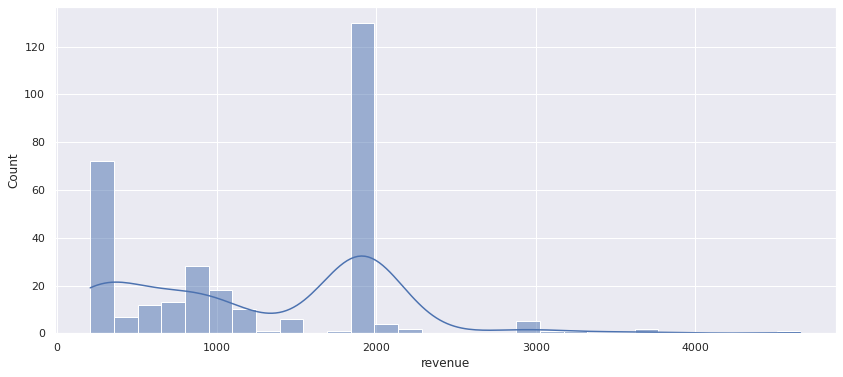

In [18]:
sns.histplot(summary_with_revenue.query('group == "B"').revenue, bins=30, kde=True);

#### Мы имеем дело с ненормальным распределением (становится очевидно по графику), и это подтверждается тестом Шапиро-Уилка:

In [19]:
# p-value << 0.05, значит, распределение ненормальное
stats.shapiro(summary_with_revenue.query('group == "A"').revenue)

ShapiroResult(statistic=0.7358548641204834, pvalue=1.5417730980793465e-10)

In [20]:
stats.shapiro(summary_with_revenue.query('group == "B"').revenue)

ShapiroResult(statistic=0.8552882671356201, pvalue=1.665431681028873e-16)

####  Для проведения тестирования на статистическую значимость результата используем бутстрап: он позволяет многократно извлекать подвыборки из выборки, полученной в рамках эксперимента; в полученных подвыборках считаются статистики (среднее, медиана и т.п.), из которых можно получить ее распределение и взять доверительный интервал. Данный метод является методом непараметрической статистики.


In [21]:
from scipy.stats import norm

In [22]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа


def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95,  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, replace=True  # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(boot_len, replace=True).values

        boot_data.append(
            statistic(samples_1 - samples_2)
        )  # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2

    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)

    plt.style.use("ggplot")
    plt.vlines(ci, ymin=0, ymax=50, linestyle="--")
    plt.xlabel("boot_data")
    plt.ylabel("frequency")
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data, "ci": ci, "p_value": p_value}

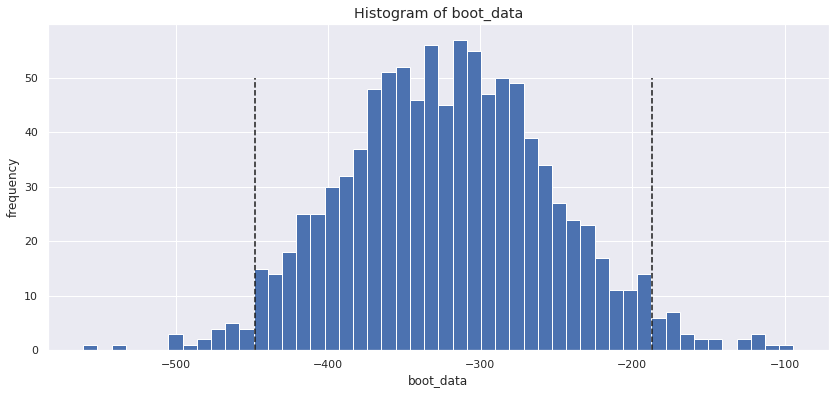

In [23]:
# Применим бутстрап на наших выборках. В качестве статистики используем средние значения.
booted_data = get_bootstrap(
    summary_with_revenue.query('group == "A"').revenue,
    summary_with_revenue.query('group == "B"').revenue,
)

In [24]:
# Получаем p-value << 0.05, что говорит нам о статистической значимости результата.
booted_data["p_value"]

2.605810195463751e-06

#### Сделаем повторную проверку - проверим гипотезу на непараметрическом тесте Манна-Уитни: требования для его проведения минимальны, и численность сравниваемых групп может быть не одинаковой.

In [25]:
# Снова получаем p-value << 0.05 и подтверждаем полученный результат.
stats.mannwhitneyu(
    summary_with_revenue.query('group == "A"').revenue,
    summary_with_revenue.query('group == "B"').revenue,
)

MannwhitneyuResult(statistic=8961.0, pvalue=0.00023939080114586078)

#### В ходе проведённого выше этапа исследования мы выявили статистически значимые различия между показателями ARPPU в контрольной и тестовой выборках. Этот вывод был подстверждён двумя различными по алгоритму проведения тестами.
#### Полученная статистическая значимость различий означает, что наше нововведение действительно оказало влияние на метрику ARPPU и уже имеет смысл рассмотреть полноценное внедрение новой модели оплаты.

#### Теперь обратим внимание на вторую, не менее важную для нас метрику - конверсию.

In [26]:
# Нас больше не интересует размер дохода с пользователя:
# теперь мы ориентируемся на бинарную переменную наличия оплаты.
# Используем уже сформированный ранее датафрейм, в котором
# отобраны только активные пользователи вне зависимости от наличия оплаты.

summary["revenue"] = summary.revenue.apply(lambda x: 0 if np.isnan(x) else 1)
summary.head()

,user_id,group,country,platform,sex,revenue
0,8029,B,Russia,ios,male,0
1,1735,B,Sweden,ios,male,0
2,7697,B,Russia,android,male,0
3,1421,B,Sweden,android,female,0
4,1704,B,Russia,ios,male,0


#### Эта метрика интересует нас в том числе и в качестве "подстраховки" на случай, если модель оплаты оказалась непригодной к использованию в каких-либо сегментах пользователей.

In [27]:
# Чтобы не повторять один и тот же код для расчётов в разрезах, зададим функцию:


def get_conversion_rate(data, separation_parameters):
    # data has to contain the columns 'revenue' with binary values (0, 1)
    # separation_parameters has to be a string or a list

    number_of_conv_users = (
        data.groupby(separation_parameters, as_index=False)
        .agg({"revenue": "sum"})
        .rename(columns={"revenue": "converted_users"})
    )  # count the number of converted users

    number_of_users = (
        data.groupby(separation_parameters, as_index=False)
        .agg({"revenue": "count"})
        .rename(columns={"revenue": "all_users"})
    )  # count the number of all users

    cr = number_of_users.merge(number_of_conv_users, on=separation_parameters)
    cr["conversion_rate"] = cr.converted_users / cr.all_users

    return cr

In [28]:
get_conversion_rate(summary, "group")

,group,all_users,converted_users,conversion_rate
0,A,1538,78,0.050715
1,B,6803,314,0.046156


In [29]:
get_conversion_rate(summary, ["group", "country"]).pivot(
    index="group", columns="country", values="conversion_rate"
)

country,Russia,Sweden
group,,
A,0.046995,0.056180
B,0.043856,0.050627


In [30]:
get_conversion_rate(summary, ["group", "platform"]).pivot(
    index="group", columns="platform", values="conversion_rate"
)

platform,android,ios
group,,
A,0.046763,0.055398
B,0.044626,0.048077


In [31]:
get_conversion_rate(summary, ["group", "sex"]).pivot(
    index="group", columns="sex", values="conversion_rate"
)

sex,female,male
group,,
A,0.049137,0.052229
B,0.045401,0.046907


#### Заметим, что в каждом разрезе в группе (В) CR стало на десятые доли процента ниже, чем в группе (А).
#### Проверим статистическую значимость результата на всём объеме данных: здесь мы работаем с качественной (бинарной) переменной, поэтому для оценки значимости различий между группами используем критерий согласия Пирсона или же хи-квадрат:

In [32]:
# Подготовим перекрестную таблицу:
pd.crosstab(summary.revenue, summary.group)

group,A,B
revenue,,
0,1460,6489
1,78,314


In [41]:
# p-value > 0.05, значит, мы НЕ можем отклонить нулевую гипотезу 
# и переменные не имеют существенной связи.
# Значит, наше нововведение с большей вероятностью
# не оказывает влияние на метрику конверсии.
stat, p, dof, expected = stats.chi2_contingency(
    pd.crosstab(summary.revenue, summary.group)
)
print("p-value =", p)

p-value = 0.48625240457231045


#### Результаты проверки значимости различий между двумя группами показали, что изменения не оказали статистически значимого влияния на метику конверсии. Значит, выявленные ранее различия, вероятнее всего, являются случайными, и наш эксперимент не понёс за собой никаких статистически значимых изменений метрики CR в тестовой группе.

#### В результате анализа итогов эксперимента по внедрению новой модели оплаты коллекций шаблонов было выявлено, что нововведение оказывает статистически значимое влияние на метрику ARPPU - показатель существенно возрос во всех сегментах. В то же время эксперимент никак не проявил себя с точки зрения метрики конверсии в оплату, откуда следует отстуствие явных сбоев модели.
#### Основываясь на результатах проведенного тестирования, мы можем сделать вывод о целесообразности внедрения новой модели оплаты коллекций шаблонов на всех остальных пользователей.

## Задание 2
#### Одной из основных задач аналитика является не только построение моделей, но и создание дашбордов, которые позволяют отслеживать изменения метрик и принимать на их основе оптимальные решения. Ваш руководитель хочет узнать, как обстоят дела с использованием приложения и вовлечённостью пользователей, и очень просит спроектировать ему дашборд.

In [34]:
# Преобразуем имеющиеся данные в удобный для визуализации результатов теста файл

In [35]:
groups.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [36]:
active_users["active_user"] = 1
active_users.head()

,user_id,country,platform,sex,active_user
0,8029,Russia,ios,male,1
1,1735,Sweden,ios,male,1
2,7697,Russia,android,male,1
3,1421,Sweden,android,female,1
4,1704,Russia,ios,male,1


In [37]:
purchases["converted_user"] = 1
purchases.head()

,user_id,revenue,converted_user
0,4412,1000.0,1
1,9000,701.0,1
2,9001,700.0,1
3,9002,702.0,1
4,5790,1002.0,1


In [38]:
df = groups.merge(active_users, how="left", on="user_id").merge(
    purchases, how="left", on="user_id"
)
df["active_user"].fillna(0, inplace=True)
df["converted_user"].fillna(0, inplace=True)
df = df.astype({"active_user": "int", "converted_user": "int"})
df.head()

,user_id,group,country,platform,sex,active_user,revenue,converted_user
0,9149,B,NaN,NaN,NaN,0,NaN,0
1,9150,B,NaN,NaN,NaN,0,NaN,0
2,9151,A,NaN,NaN,NaN,0,NaN,0
3,9152,B,NaN,NaN,NaN,0,NaN,0
4,9153,B,NaN,NaN,NaN,0,NaN,0


In [39]:
# Теперь запишем датафрейм в csv файл для работы в Tableau

"""
with open('data.csv', 'w') as f:
    f.write(df.to_csv(index=True, header=True))
""";

#### Ссылка на дашборд: https://public.tableau.com/app/profile/starikova.alexandra/viz/ABTestResults/ABTestResults#1